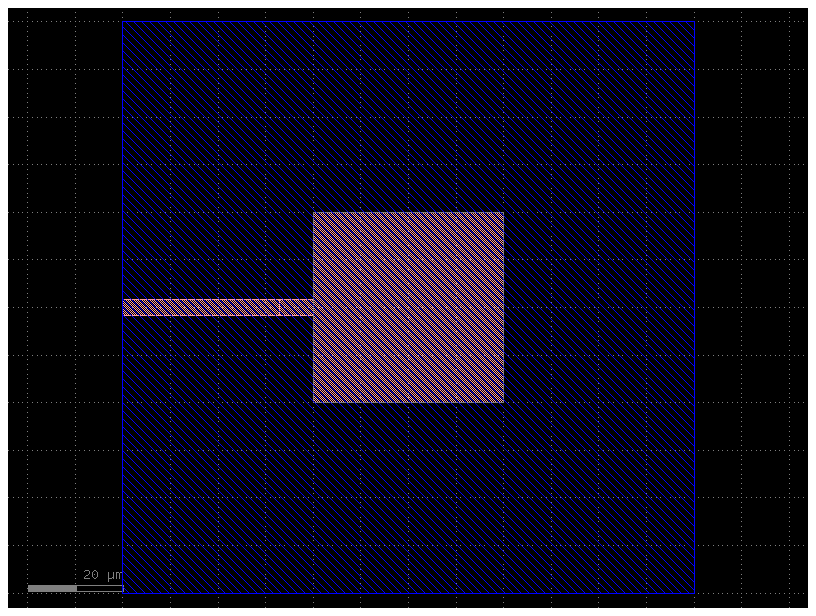

In [7]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import Image

path = os.path.join("runs", "mfd")

# length and frequency units are arbitrary
frequency = 5  # GHz
wl1f = 300  # vacuum wavelength at 1 unit of frequency in your units
wavelength = wl1f / frequency  # characteristic wavelength
frequencies = np.linspace(4, 6, 9).tolist()
bandwidth = max(frequencies) - min(frequencies)

# microstrip
w_wg = 3.5  # mm
thickness = 0.1  # mm
height = 1.61  # mm
neff = np.sqrt(2.865)  # effective index, from microstrip calculator
c = 1 / neff  # relative signal speed, from microstrip calculator

wl_sig = wl1f * c / frequency  # mm
l=40
w=40
l_wg=2*w_wg
lateral_port_margin = height_port_margin = 2 * height
source_port_margin = 1 * (w_wg + 2 * lateral_port_margin)
margin=l 

# layers
WG = 1, 0
BBOX = 10, 0
DESIGN = 100, 0

# make geometry in gdsfadory
# alternatively can import .gds into gdsfadory
c = gf.Component()
dut = lumi.mimo(
    l,
    w,
    west=1,
    w_wg=w_wg,
    l_wg=l_wg,
    init=1,  # solid slab
    layer_wg=WG,
    layer_design=DESIGN,
    centered=True,
)
info = {"designs": [{"ports": dut.info.ports}]}
dut = c << dut
ext = c << gf.components.straight(margin-l_wg, width=w_wg)
ext.connect("o2", dut.ports["o1"])
c.add_port(f"o1", port=dut.ports["o1"])

c << gf.components.bbox(component=c, layer=BBOX, top=margin, bottom=margin,right=margin)
c.plot()

Solving port modes with FEM...


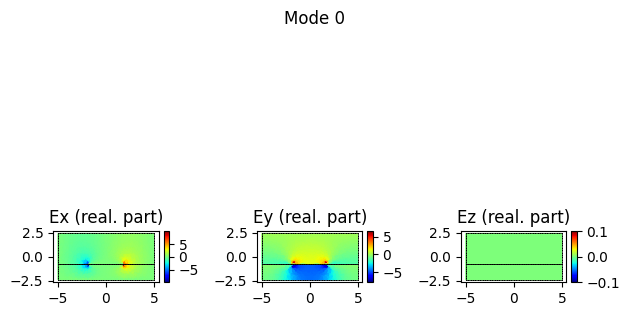

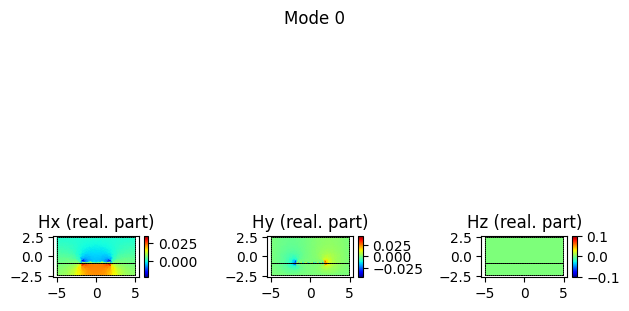

c:\Users\default.LAPTOP-HMRU58MH\anaconda3\Lib\site-packages\skfem\assembly\form\linear_form.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  data[ixs] = self._kernel(vbasis.basis[i], w, dx)


using simulation folder c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\docs\runs\mfd
loading problem from c:\Users\default.LAPTOP-HMRU58MH\Desktop\lumi\luminescent\docs\runs\mfd



FileNotFoundError: [WinError 2] The system cannot find the file specified

In [13]:
# adaptive meshing
nres = 16
dx0 = wavelength / nres

layer_stack = LayerStack(
    layers={
        "design": LayerLevel(
            layer=LogicalLayer(layer=DESIGN),
            zmin=height,
            thickness=thickness,
            material="DESIGN",
            mesh_order=0,
        ),
        "sig": LayerLevel(
            layer=LogicalLayer(layer=WG),
            zmin=height,
            thickness=thickness,
            material="PEC",
            mesh_order=1,
        ),
        "wg": LayerLevel(
            layer=LogicalLayer(layer=WG),
            zmin=height,
            thickness=thickness,
            material="PECwg",
            mesh_order=2,
        ),
        "core": LayerLevel(
            layer=LogicalLayer(layer=BBOX),
            zmin=0.0,
            thickness=height,
            material="FR",
            mesh_order=20,
        ),
    }
)

dx = w_wg / 4  # 5 mesh points across the strip
nPEC = dx0 / (dx)  # mesh density relative to vacuum
epsFR=3.68
nFR = np.sqrt(epsFR) 
materials_library = {
    "air": lumi.Material(),
    "FR": lumi.Material(epsilon=epsFR),
    "PEC": lumi.PECMaterial(mesh_density=nPEC),
    "PECwg": lumi.PECMaterial(mesh_density=nFR),
    "DESIGN": lumi.PlaceholderMaterial(mesh_density=nPEC),
    'background': lumi.Material(),
}

R = (l + 2 * margin) / 2
angres = np.pi / 180 * 5  # angular resolution
θmax = np.pi / 2
φmax = 2 * np.pi
ports = [
    lumi.SpherePort(
        name="o2", origin=(0, 0, 0), radius=0.9 *R, angres=angres, θmax=θmax, φmax=φmax
    ),
]

modes = [
    # lumi.Mode(
    #     frequency=f,
    #     metallic_boundaries=["-y", "sig"],
    #     nmodes=1,
    # )
    lumi.Mode(
        ports=["o1"],
        frequency=frequency,
        metallic_boundaries=["-y", "sig"],
        nmodes=1,
    )
]

sources = [
    lumi.Source(
        "o1", frequency=frequency, bandwidth=bandwidth, source_port_margin=source_port_margin
    )
]
designs = [
    lumi.Design(
        name="d1",
        layer=DESIGN,
        lmin=2,
        fill_material="PEC",
        void_material="air",
    )
]
# optimization targets of Tsim params.
# o1@0 means optical port 1 on mode 0 (fundamental mode)
targets = [
    lumi.Target(
        # key=f"To{i+2}@0,o1@0",
        key=f"To1@0,o1@0",
        target=0,
        weight=1 / len(frequencies),
        frequency=f,
    )
    for i, f in enumerate(frequencies)
]

optimizer = lumi.Optimizer(stoploss=0.3, iters=50, momentum=0.8,contrast=.8)
Tsim=4*(neff*(l+w+l_wg+source_port_margin)+R)/wavelength
kwargs = dict(
    path=path,  # path to make problem folder
    component=c,
    frequencies=frequencies,
    frequency=frequency,
    wl1f=wl1f,
    boundaries=["PML", "PML", ["PEC", "PML"]],
    modes=modes,
    info=info,
    sources=sources,
    #
    lateral_port_margin=lateral_port_margin,
    height_port_margin=[0, height_port_margin],
    zmin=0,
    zmax=R,
    #
    materials_library=materials_library,
    layer_stack=layer_stack,
    #
    gpu="CUDA",
    nres=nres,  # number of grid points per wavelength in material (not vacuum)
    relative_courant=0.9,
    Tsim=Tsim,
    force=True,  # overwrite files in existing path
    #
    designs=designs,
    targets=targets,
    optimizer=optimizer,
)
lumi.make(**kwargs)
lumi.solve(path)
display(Image(filename=os.path.join(path, "halfway.png")))
lumi.plot(path)